In [2]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

In [5]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [6]:
from datasets import train_test_random_split, load_dsprites
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAEDSprites

In [7]:
dataset = load_dsprites("../datasets/dsprites.npz")

In [8]:
dataset = torch.from_numpy(dataset)

In [9]:
n_imgs = 50000
indices = torch.randperm(dataset.size(0))[:n_imgs]
dataset = dataset[indices]

In [10]:
data_train, data_test = train_test_random_split(dataset, 0.8)

In [23]:
batch_size = 1
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [18]:
model = BetaVAEDSprites()
model.to(device)

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [19]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

In [24]:
train_beta_vae(model, 10, train_loader, optimizer, 1, 'bernoulli', device=device)

RuntimeError: CUDA error: CUBLAS_STATUS_INTERNAL_ERROR when calling `cublasCreate(handle)`

In [13]:
test_beta_vae(model, test_loader, 1, 'bernoulli')

Test loss: 103.14901733398438


In [29]:
torch.save(model, 'betavae_beta1_e10.dat')

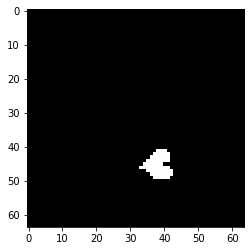

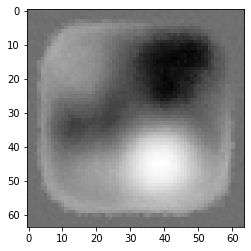

In [19]:
index = 4
original = dataset[index].float()
recon, mu, logvar = model(original)
plt.imshow(original, cmap='Greys_r')
plt.show()
plt.imshow(recon.detach().view(64,64), cmap='Greys_r')
plt.show()

In [ ]:
torch.save(model, 'betavae_beta1_e10.dat')